In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # To manage warnings
warnings.filterwarnings('ignore')

sns.set()
plt.style.use("dark_background")

In [3]:
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

In [4]:
plt.style.use('ggplot')

In [5]:
nifty50_symbols = [
    "RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS","ICICIBANK.NS","HINDUNILVR.NS",
    "SBIN.NS","BHARTIARTL.NS","KOTAKBANK.NS","LT.NS","AXISBANK.NS","ITC.NS",
    "HCLTECH.NS","MARUTI.NS","ASIANPAINT.NS","TITAN.NS","ULTRACEMCO.NS",
    "SUNPHARMA.NS","WIPRO.NS","POWERGRID.NS","BAJFINANCE.NS","BAJAJFINSV.NS",
    "ADANIENT.NS","ADANIPORTS.NS"
]

nifty50_symbols[:5]  # show sample


['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS']

In [6]:
stock = "HDFCBANK.NS"

df = yf.download(stock, period="1y")
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
Date,,,,,
2024-11-05,867.203003,869.595649,837.627795,840.143775,44232406
2024-11-06,865.920349,873.936988,861.036354,873.936988,27787910
2024-11-07,861.628418,868.732346,857.410408,860.518422,18895456
2024-11-08,865.525635,869.151670,861.282995,864.316996,19902986
2024-11-11,871.371704,879.511676,863.922348,865.575057,24565362


In [7]:
# Keep only the columns we need and make a clean copy
base_cols = ["Open","High","Low","Close","Adj Close","Volume"]
df = df[[c for c in base_cols if c in df.columns]].copy()

# Ensure datetime index, sorted, no duplicates
df.index = pd.to_datetime(df.index)
df = df[~df.index.duplicated(keep="last")].sort_index()

print("Shape:", df.shape)
print("Index type:", type(df.index))
print(df.dtypes)
df.head(3)


Shape: (248, 5)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Price   Ticker     
Open    HDFCBANK.NS    float64
High    HDFCBANK.NS    float64
Low     HDFCBANK.NS    float64
Close   HDFCBANK.NS    float64
Volume  HDFCBANK.NS      int64
dtype: object


Price,Open,High,Low,Close,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
Date,,,,,
2024-11-05,840.143775,869.595649,837.627795,867.203003,44232406
2024-11-06,873.936988,873.936988,861.036354,865.920349,27787910
2024-11-07,860.518422,868.732346,857.410408,861.628418,18895456


In [8]:
print(df.columns)
df.head()

MultiIndex([(  'Open', 'HDFCBANK.NS'),
            (  'High', 'HDFCBANK.NS'),
            (   'Low', 'HDFCBANK.NS'),
            ( 'Close', 'HDFCBANK.NS'),
            ('Volume', 'HDFCBANK.NS')],
           names=['Price', 'Ticker'])


Price,Open,High,Low,Close,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
Date,,,,,
2024-11-05,840.143775,869.595649,837.627795,867.203003,44232406
2024-11-06,873.936988,873.936988,861.036354,865.920349,27787910
2024-11-07,860.518422,868.732346,857.410408,861.628418,18895456
2024-11-08,864.316996,869.151670,861.282995,865.525635,19902986
2024-11-11,865.575057,879.511676,863.922348,871.371704,24565362


In [9]:
# If dataframe has multiindex columns like (Price, Ticker)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]  # keep only 'Open', 'High', 'Low', etc.
    print("Flattened columns:", df.columns.tolist())
else:
    print("No multiindex — good.")


Flattened columns: ['Open', 'High', 'Low', 'Close', 'Volume']


In [10]:

# Coerce numerics safely
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows where Close is missing, then forward-fill others if any gap
df = df.dropna(subset=["Close"])
df = df.ffill()

# Final type checks
print("Any NaN now?", df.isna().sum().to_dict())
print("Close dtype:", df["Close"].dtype)
print("Rows:", len(df))
df.tail(3)


Any NaN now? {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}
Close dtype: float64
Rows: 248


,Open,High,Low,Close,Volume
Date,,,,,
2025-10-31,994.0,1004.450012,981.150024,987.299988,23221330
2025-11-03,985.0,994.549988,983.299988,992.650024,16607180
2025-11-04,987.0,997.000000,983.700012,985.250000,20024544


In [11]:
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()

df[["Close","SMA_20","SMA_50"]].tail()


,Close,SMA_20,SMA_50
Date,,,
2025-10-29,1007.849976,986.595001,974.685999
2025-10-30,998.150024,988.952502,974.612999
2025-10-31,987.299988,990.055002,974.447999
2025-11-03,992.650024,991.430002,974.419000
2025-11-04,985.250000,992.020001,974.212001


In [12]:
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

df[["Close","EMA_20"]].tail()


,Close,EMA_20
Date,,
2025-10-29,1007.849976,990.063954
2025-10-30,998.150024,990.834056
2025-10-31,987.299988,990.497478
2025-11-03,992.650024,990.702483
2025-11-04,985.250000,990.183199


In [13]:
delta = df["Close"].diff()

gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()

rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

df[["Close","RSI"]].tail()


,Close,RSI
Date,,
2025-10-29,1007.849976,71.355265
2025-10-30,998.150024,63.785236
2025-10-31,987.299988,53.836910
2025-11-03,992.650024,59.222174
2025-11-04,985.250000,54.397382


In [14]:
ma = df["Close"].rolling(window=20).mean()
std = df["Close"].rolling(window=20).std()

df["BB_High"] = ma + 2*std
df["BB_Low"] = ma - 2*std

df[["Close","BB_High","BB_Low"]].tail()


,Close,BB_High,BB_Low
Date,,,
2025-10-29,1007.849976,1020.317698,952.872305
2025-10-30,998.150024,1018.536120,959.368885
2025-10-31,987.299988,1017.484400,962.625603
2025-11-03,992.650024,1016.234205,966.625799
2025-11-04,985.250000,1015.552199,968.487803


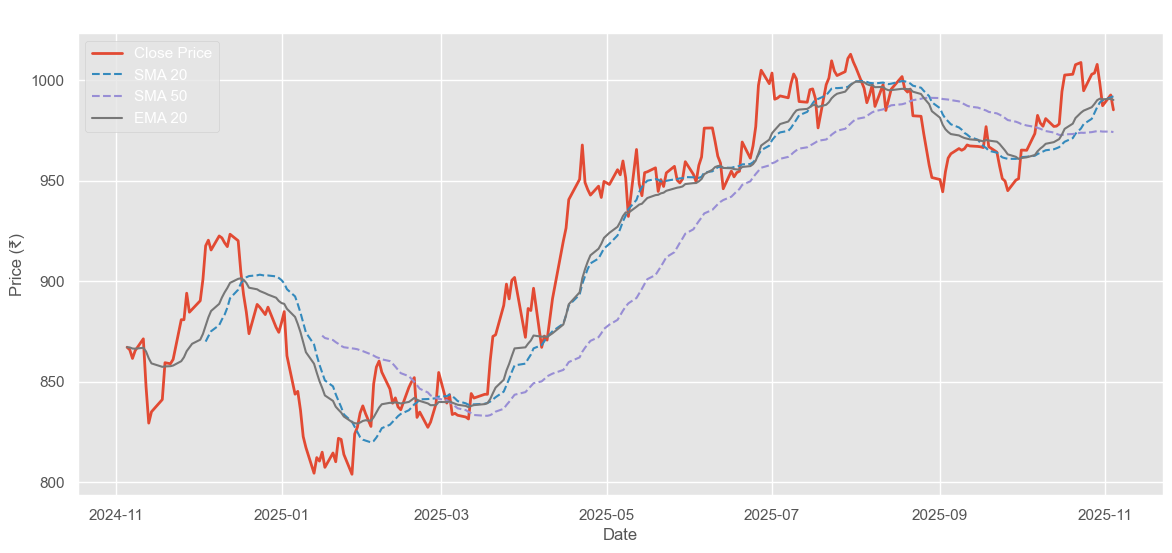

In [15]:
plt.figure(figsize=(14,6))

plt.plot(df["Close"], label="Close Price", linewidth=2)
plt.plot(df["SMA_20"], label="SMA 20", linestyle="--")
plt.plot(df["SMA_50"], label="SMA 50", linestyle="--")
plt.plot(df["EMA_20"], label="EMA 20", linewidth=1.5)

plt.title(f"{stock} — Price with SMA & EMA")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.show()


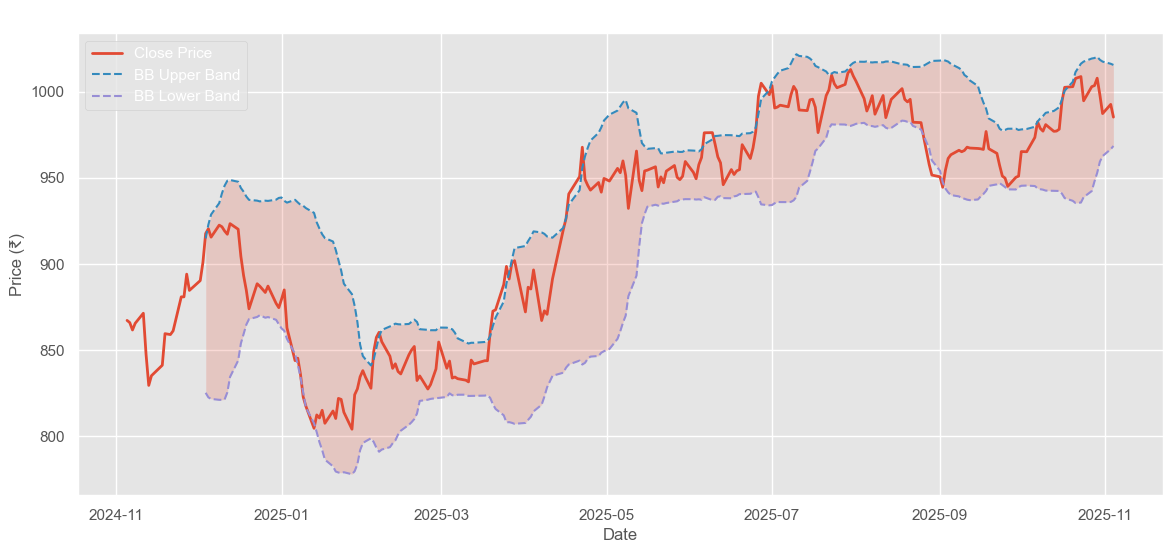

In [16]:
plt.figure(figsize=(14,6))

plt.plot(df["Close"], label="Close Price", linewidth=2)
plt.plot(df["BB_High"], label="BB Upper Band", linestyle="--")
plt.plot(df["BB_Low"], label="BB Lower Band", linestyle="--")

plt.fill_between(df.index, df["BB_Low"], df["BB_High"], alpha=0.2)

plt.title(f"{stock} — Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (₹)")
plt.legend()
plt.show()


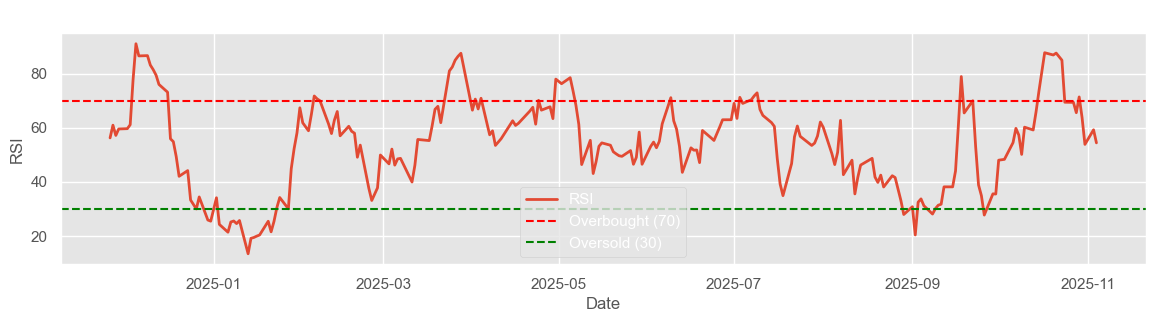

In [17]:
plt.figure(figsize=(14,3))

plt.plot(df["RSI"], label="RSI", linewidth=2)
plt.axhline(70, color='red', linestyle='--', label="Overbought (70)")
plt.axhline(30, color='green', linestyle='--', label="Oversold (30)")

plt.title(f"{stock} — RSI")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.show()


In [18]:
def get_data(symbol):
    df = yf.download(symbol, period="1y", progress=False)

    # Fix MultiIndex (Open, High, Low, Close, Volume)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]

    # Convert all columns to numeric safely
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Remove rows where Close is missing
    df = df.dropna(subset=["Close"]).ffill()

    return df


In [19]:
def add_indicators(df):
    # SMA & EMA
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["SMA_50"] = df["Close"].rolling(50).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

    # RSI
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    ma = df["Close"].rolling(20).mean()
    std = df["Close"].rolling(20).std()
    df["BB_High"] = ma + 2*std
    df["BB_Low"] = ma - 2*std

    return df


In [20]:
def score_stock(df):
    last = df.iloc[-1]
    score = 0

    # SMA trend
    if last["SMA_20"] > last["SMA_50"]:
        score += 1

    # EMA trend
    if last["EMA_20"] > last["SMA_20"]:
        score += 1

    # RSI buy zone
    if last["RSI"] < 30:
        score += 1

    # RSI overbought risk
    if last["RSI"] > 70:
        score -= 1

    # Bollinger logic
    if last["Close"] < last["BB_Low"]:
        score += 1
    if last["Close"] > last["BB_High"]:
        score -= 1

    return {
        "Price": round(last["Close"], 2),
        "RSI": round(last["RSI"], 2),
        "Score": score
    }


In [21]:
def analyze_stock(symbol):
    try:
        df = get_data(symbol)
        df = add_indicators(df)
        result = score_stock(df)
        result["Stock"] = symbol
        return result
    except Exception as e:
        return {"Stock": symbol, "Error": str(e)}


In [22]:
analyze_stock("HDFCBANK.NS")


{'Price': 985.25, 'RSI': 54.4, 'Score': 1, 'Stock': 'HDFCBANK.NS'}

In [23]:
results = [analyze_stock(s) for s in nifty50_symbols]
df_results = pd.DataFrame(results).sort_values(by="Score", ascending=False)
df_results


,Price,RSI,Score,Stock
13,15374.00,23.52,3,MARUTI.NS
12,1529.10,62.56,2,HCLTECH.NS
2,1467.90,50.11,2,INFY.NS
22,2419.80,32.08,2,ADANIENT.NS
21,2073.20,59.12,2,BAJAJFINSV.NS
19,279.05,39.26,2,POWERGRID.NS
17,1690.00,62.36,2,SUNPHARMA.NS
9,3924.40,68.20,2,LT.NS
10,1226.60,65.58,2,AXISBANK.NS
11,408.90,62.98,2,ITC.NS


In [24]:
from sklearn.linear_model import LinearRegression
import numpy as np

def predict_price(df, future_days=7):
    df = df.copy()
    df = df.dropna(subset=["Close"])

    df["Index"] = np.arange(len(df))
    
    # Use last 60 days
    data = df.tail(60)

    X = data["Index"].values.reshape(-1,1)
    y = data["Close"].values

    model = LinearRegression()
    model.fit(X, y)

    # Predict future price
    future_index = np.array([[data["Index"].iloc[-1] + future_days]])
    predicted_price = model.predict(future_index)[0]

    return round(predicted_price, 2)


In [25]:
def analyze_stock(symbol):
    try:
        df = get_data(symbol)
        df = add_indicators(df)
        score = score_stock(df)
        
        prediction = predict_price(df)
        current = score["Price"]

        score["Stock"] = symbol
        score["Predicted_Price"] = prediction
        score["Expected_Return_%"] = round(((prediction - current) / current) * 100, 2)

        return score
    
    except Exception as e:
        return {"Stock": symbol, "Error": str(e)}


In [26]:
results = [analyze_stock(s) for s in nifty50_symbols]
df_results = pd.DataFrame(results).sort_values(by="Expected_Return_%", ascending=False)
df_results


,Price,RSI,Score,Stock,Predicted_Price,Expected_Return_%
13,15374.00,23.52,3,MARUTI.NS,17308.42,12.58
22,2419.80,32.08,2,ADANIENT.NS,2633.39,8.83
20,1057.00,63.46,1,BAJFINANCE.NS,1123.07,6.25
8,2096.60,40.41,1,KOTAKBANK.NS,2200.99,4.98
21,2073.20,59.12,2,BAJAJFINSV.NS,2152.85,3.84
19,279.05,39.26,2,POWERGRID.NS,289.62,3.79
10,1226.60,65.58,2,AXISBANK.NS,1270.55,3.58
23,1444.40,54.31,1,ADANIPORTS.NS,1483.25,2.69
5,2445.70,39.86,0,HINDUNILVR.NS,2496.87,2.09
18,237.92,32.46,0,WIPRO.NS,242.83,2.06


In [27]:
def recommend_stocks(top_n=5):
    results = [analyze_stock(s) for s in nifty50_symbols]
    df_results = pd.DataFrame(results)

    # Remove failed stocks if any error
    df_results = df_results.dropna(subset=["Expected_Return_%"])

    # Sort highest return first
    df_results = df_results.sort_values(by="Expected_Return_%", ascending=False)

    return df_results.head(top_n)


In [28]:
recommend_stocks()


,Price,RSI,Score,Stock,Predicted_Price,Expected_Return_%
13,15374.0,23.52,3,MARUTI.NS,17308.42,12.58
22,2419.8,32.08,2,ADANIENT.NS,2633.39,8.83
20,1057.0,63.46,1,BAJFINANCE.NS,1123.07,6.25
8,2096.6,40.41,1,KOTAKBANK.NS,2200.99,4.98
21,2073.2,59.12,2,BAJAJFINSV.NS,2152.85,3.84


In [29]:
def speak_recommendations(top_n=5):
    df = recommend_stocks(top_n)

    print("Top Stock Recommendations:\n")
    for i, row in df.iterrows():
        stock = row["Stock"].replace(".NS", "")
        price = row["Price"]
        exp = row["Expected_Return_%"]
        print(f"{stock}: current ₹{price}, expected return {exp}%")


In [30]:
speak_recommendations(5)

Top Stock Recommendations:

MARUTI: current ₹15374.0, expected return 12.58%
ADANIENT: current ₹2419.8, expected return 8.83%
BAJFINANCE: current ₹1057.0, expected return 6.25%
KOTAKBANK: current ₹2096.6, expected return 4.98%
BAJAJFINSV: current ₹2073.2, expected return 3.84%


In [31]:
def get_stock_recommendation(duration="1month", capital=20000, risk="medium", top_n=5):
    # Convert duration to forecast days
    duration_map = {
        "1day": 1,
        "1week": 7,
        "1month": 30,
        "3months": 90
    }

    future_days = duration_map.get(duration, 30)

    # Analyze all stocks
    results = []
    for symbol in nifty50_symbols:
        result = analyze_stock(symbol)

        if "Error" in result:
            continue

        # Filter by risk preference using RSI + Bollinger logic
        rsi = result["RSI"]
        exp = result["Expected_Return_%"]
        score = result["Score"]

        if risk == "low":
            if rsi > 70 or score < 0:
                continue  # avoid risky stocks
        elif risk == "high":
            pass  # allow all including aggressive trades
        # medium risk → no filter

        results.append(result)

    df = pd.DataFrame(results)

    # Sort by expected return
    df = df.sort_values(by="Expected_Return_%", ascending=False)

    # Calculate quantity user can buy
    df["Quantity"] = (capital // df["Price"]).astype(int)

    return df.head(top_n)


In [32]:
get_stock_recommendation(
    duration="1month",
    capital=20000,
    risk="low",
    top_n=5
)


,Price,RSI,Score,Stock,Predicted_Price,Expected_Return_%,Quantity
10,15374.0,23.52,3,MARUTI.NS,17308.42,12.58,1
17,2419.8,32.08,2,ADANIENT.NS,2633.39,8.83,8
15,1057.0,63.46,1,BAJFINANCE.NS,1123.07,6.25,18
5,2096.6,40.41,1,KOTAKBANK.NS,2200.99,4.98,9
16,2073.2,59.12,2,BAJAJFINSV.NS,2152.85,3.84,9


In [33]:
def speak_user_recommendation(duration="1month", capital=20000, risk="medium", top_n=5):
    df = get_stock_recommendation(duration, capital, risk, top_n)

    print(f"\n Investment Plan")
    print(f"Duration: {duration}, Capital: ₹{capital}, Risk: {risk}\n")
    print("Recommended Stocks:\n")

    for idx, row in df.iterrows():
        stock = row["Stock"].replace(".NS","")
        qty = row["Quantity"]
        price = row["Price"]
        exp = row["Expected_Return_%"]

        print(f"{stock} — Buy {qty} shares @ ₹{price} | Expected Return: {exp}%")

    print("\n Bunny Tip: Diversify & monitor markets daily.\n")


In [34]:
speak_user_recommendation(
    duration="1month",
    capital=20000,
    risk="low",
    top_n=3
)



 Investment Plan
Duration: 1month, Capital: ₹20000, Risk: low

Recommended Stocks:

MARUTI — Buy 1 shares @ ₹15374.0 | Expected Return: 12.58%
ADANIENT — Buy 8 shares @ ₹2419.8 | Expected Return: 8.83%
BAJFINANCE — Buy 18 shares @ ₹1057.0 | Expected Return: 6.25%

 Bunny Tip: Diversify & monitor markets daily.

